## "An exploration of Wu et al, Lancet, 2020"
#### author: "Caroline Colijn"
#### date: "11/02/2020"


In [2]:
install.packages("ggplot2")
install.packages("deSolve")
install.packages("tidyr")
library(deSolve)
library(ggplot2)
library(tidyr)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘rlang’, ‘ellipsis’, ‘dplyr’, ‘vctrs’, ‘lifecycle’



## Introduction

This is an implementation and exploration of the susceptible-exposed-infectious (SEI) model in Wu et al, Lancet, https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext. 


## Data

M. Hayati digitized the paper's supplementary data. This could be updated but as it stands the model does not include the containment measures and so unless those are added too, going out further into late January and February won't make sense. It would be quite straightforward to add control measures: decrease the travel terms, a lot, and decrease $R_0$. 


In [11]:
wudata=read.csv("./Hackathon2020/Modelling/wu_lancet_supplement-Table1.csv",stringsAsFactors = F,na.strings = "-")
head(wudata)

Country.region,City,Sex,Ag.e,Date.of.symptom.onset,Date..of.confirmation,Time..between.symptoms........onset.and..confirmation..days.
Thailand,Bangkok,F,61,1/5/2020,1/12/2020,7
Thailand,Bangkok,F,74,1/5/2020,1/17/2020,12
Thailand,Bangkok,M,68,1/19/2020,1/19/2020,0
Thailand,Nakhon Pathom,F,73,12/31/2019,1/22/2020,22
Thailand,Bangkok,F,33,1/21/2020,1/24/2020,3
Thailand,NA,NA,NA,NA,1/26/2020,NA


I can see two options for those missing time of symptom onset: (1) use mean delay to confirmation and subtract from confirmation time (or better imputation) or (2)  exclude those cases. For now, as the simplest option, I am not including them. 

It seems that Wu et al begin their model on 25 Dec 2019, so I will set up times since that date. 


In [12]:
wudata$Date.of.symptom.onset=as.Date(wudata$Date.of.symptom.onset, format = "%m/%d/%Y")
wudata$Date..of.confirmation = as.Date(wudata$Date..of.confirmation, format = "%m/%d/%Y") 
colnames(wudata)=c("country.region","City","Sex","Age","Date.symptom.onset","Date.confirmation", "time.sympt.to.confn")
wudata$symp.onset.since.dec25 = as.numeric(wudata$Date.symptom.onset-as.Date("25-12-2019",format="%d-%m-%Y"))
wudata$confn.since.dec25=as.numeric(wudata$Date.confirmation-as.Date("25-12-2019",format="%d-%m-%Y"))

Now for a simpler data frame that we can directly compare to model simulations: 


In [13]:
wufinal = data.frame(day=0:32,  xd = vapply(0:32, 
  function(x) sum(wudata$symp.onset.since.dec25==x,na.rm = TRUE),
 FUN.VALUE = 1))

Another point where the work is unclear: are the symptom onset times the same days that the individuals flew out of Wuhan? 

## ODE Model specification

We need time-varying input parameters to account for the introductions $z(t)$ and the chunyun festival adjustments for travel information. Note that I have NOT implemented control measures -- something to be added! 

The ODE model takes in the usual time, state and parameters, but also two functions. These allow parameters to vary with time. 


In [14]:
wumodel <- function(t,state,pars,zinput, chuinput) {
  with(c(as.list(state),pars), {     # make it so we can use variable and par names
    zt = zinput(t) 
    LcwT= Lcw + chuinput(t)*(LcwCH-Lcw)
    LwcT= Lwc + chuinput(t)*(LwcCH-Lwc)
#    LcwT = LcwT*travelban(t) # 1 or 0 # we should add the travelban, control measures 
#    LwcT = LwcT*travelban(t) # 1 or 0 # as anotther time-dep function
    dSdt = -(S/N)*((R0/DI)*I+ zt) + Liw + LcwT - (1/N)*(Lwi+LwcT)*S
    dEdt = (S/N)*((R0/DI)*I+ zt) -E/DL - (1/N)*(Lwi+LwcT)*E
    dIdt = E/DL - I/DI - (1/N)*(Lwi+LwcT)*I
    list(c(dSdt, dEdt, dIdt))
  })
}

Now specify the starting state, the time range, the parameters and the input functions


In [15]:
state=c(S=19e6,E=0, I=0)
times = seq(0,50, by=0.1) 
pars=list(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
       Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,z=86)
myzinput=function(t) {ifelse(t<7,pars$z, 0) } # pass this through as zinput 
mychuinput = function(t) {ifelse(t<17,0, 1)}  # unrealistic, see more below. 86 intro/day??!

Let's run the model and see what it does using the default parameters from Wu et al:


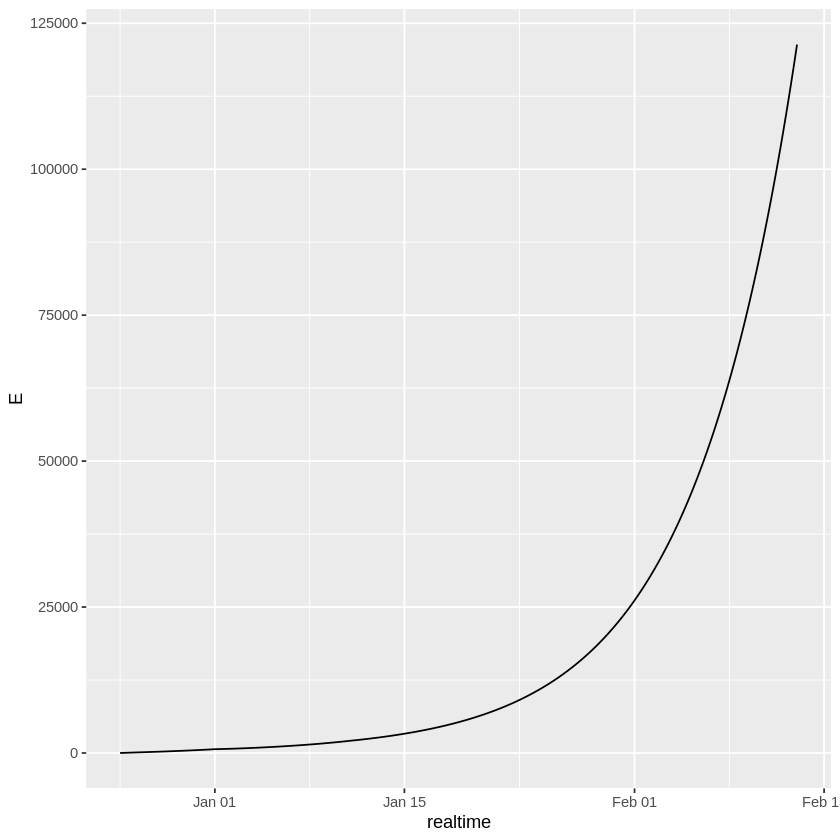

In [16]:
out = as.data.frame(ode(y= state, times=times,  func=wumodel, parms=pars,
          zinput=myzinput, chuinput=mychuinput))
out$realtime=out$time+as.Date("25-12-2019", format="%d-%m-%Y")
ggplot(data=out, aes(x=realtime,y=E))+geom_line()

How do the results depend on the assumption about the introductions, which is extremely high and not consistent with genomic data, and on the extremely high levels of travel? Three scenarios: 


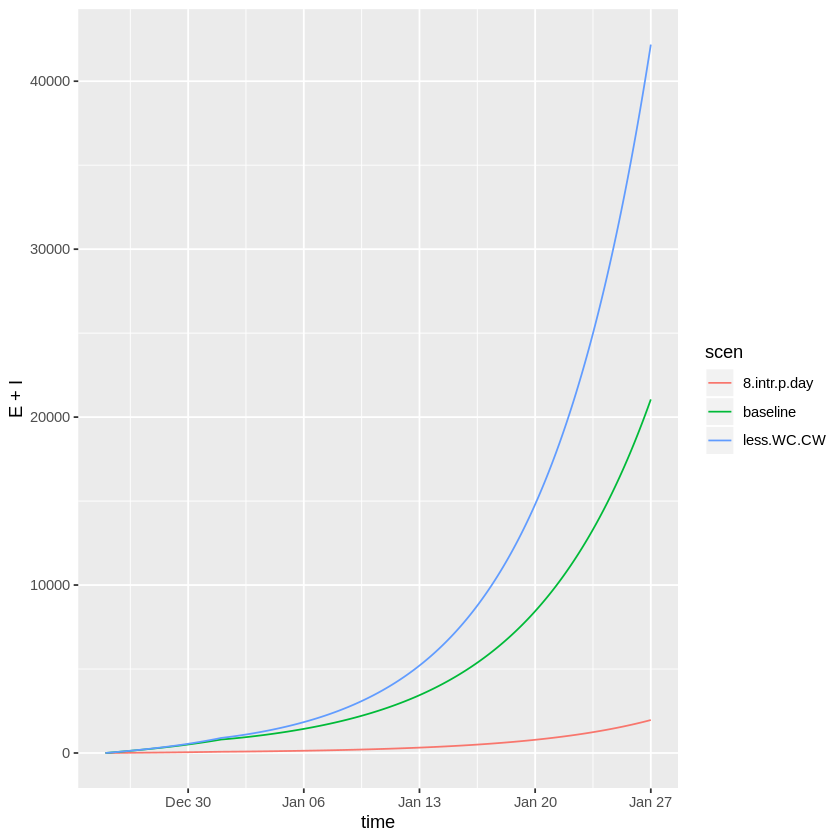

In [17]:
myzinput=function(t) {ifelse(t<7,pars["z"], 0) } # pass this through as zinput 
mychuinput = function(t) {ifelse((t<17 & t > 30),0, 1)} 
mytravelban=function(t) {ifelse( t > 30, 1,0)}
times = seq(0,33, by=0.1) 
scens=c("baseline","8.intr.p.day","less.WC.CW")
parlist=list()
parlist[[1]]=c(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
               Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,z=86) # baseline
parlist[[2]]=c(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
               Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,z=8) # fewer intros
parlist[[3]]=c(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
               Lwc=50201.3, Lcw=48731.0, LwcCH=71722.6, LcwCH=81050.0,z=86) # same intro less travel
rm(out)
out=list()
for (k in 1:3) {
  pars=parlist[[k]]
  out[[k]] = as.data.frame(ode(y= state, times=times,  func=wumodel, parms=pars,
                          zinput=myzinput, chuinput=mychuinput))
  out[[k]]$scen=scens[k]
}
pars=pars=c(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
            Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,z=86)
outall=rbind(out[[1]],out[[2]],out[[3]])
outall$time=outall$time+as.Date("25-12-2019", format="%d-%m-%Y")
ggplot(data=outall, aes(x=time,y=E+I,color=scen))+geom_line() #

The model is sensitive to both of these, but seems more sensitive to the setup period.

In fact, the WHO reports that the first 41 cases, most of whom were linked to the market, had symptom onset times from Dec 8 onward. This suggests that starting simulation with 86 introductions per day on Dec 25 is not realistic (and in fact, Wu et al did not explicitly state what date their model simulations began, but had these introductions until the market closed on 1 Jan 2020).  See the WHO report at  WHO report 
 https://www.who.int/csr/don/12-january-2020-novel-coronavirus-china/en/. 

Viral genomic data strongly suggest a single introduction (see Andrew Rambaut's post on virological.org). 

Accordingly, here is a similar model, without an introduction period, but starting quite a bit earlier with some early cases. We start earlier, with 1 or a few exposed or infectious cases, and keep the same travel and duration parameters as Wu et al. 


In [18]:
cpars=list(N=19000000, DL = 6,R0=2.6, DI = 8.4 - 6, Lwi=3633, Liw=3546,
       Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,startTime=as.Date("2019-11-29"),
       endTime=as.Date("2020-01-27"))
state=c(S=19e6,E=2, I=0)
times = seq(0, as.numeric(cpars$endTime-cpars$startTime) , by=0.1) 
mychuinput = function(t) {ifelse(t< as.numeric( as.Date("2020-01-10")-cpars$startTime),0, 1)}  
ccwumodel <- function(t,state,cpars, chuinput) {
  with(c(as.list(state),cpars), {     # make it so we can use variable and par names
    LcwT= Lcw + chuinput(t)*(LcwCH-Lcw)
    LwcT= Lwc + chuinput(t)*(LwcCH-Lwc)
#     LcwT = LcwT*travelban(t) # 1 or 0 placeholder for putting travel ban in place
#     LwcT = LwcT*travelban(t) # 1 or 0
    dSdt = -(S/N)*((R0/DI)*I) + Liw + LcwT - (1/N)*(Lwi+LwcT)*S
    dEdt = (S/N)*((R0/DI)*I) -E/DL - (1/N)*(Lwi+LwcT)*E
    dIdt = E/DL - I/DI - (1/N)*(Lwi+LwcT)*I
    list(c(dSdt, dEdt, dIdt))
  })
}

The data must be offset to accommodate our different starting time. 


In [19]:
toffset=as.numeric(as.Date("2019-12-25")-cpars$startTime)
ccwufinal = data.frame(day=c(0:(toffset-1), 0:32 + toffset),
                       xd=c(rep(0,toffset), wufinal$xd)  ) 

Run the model 


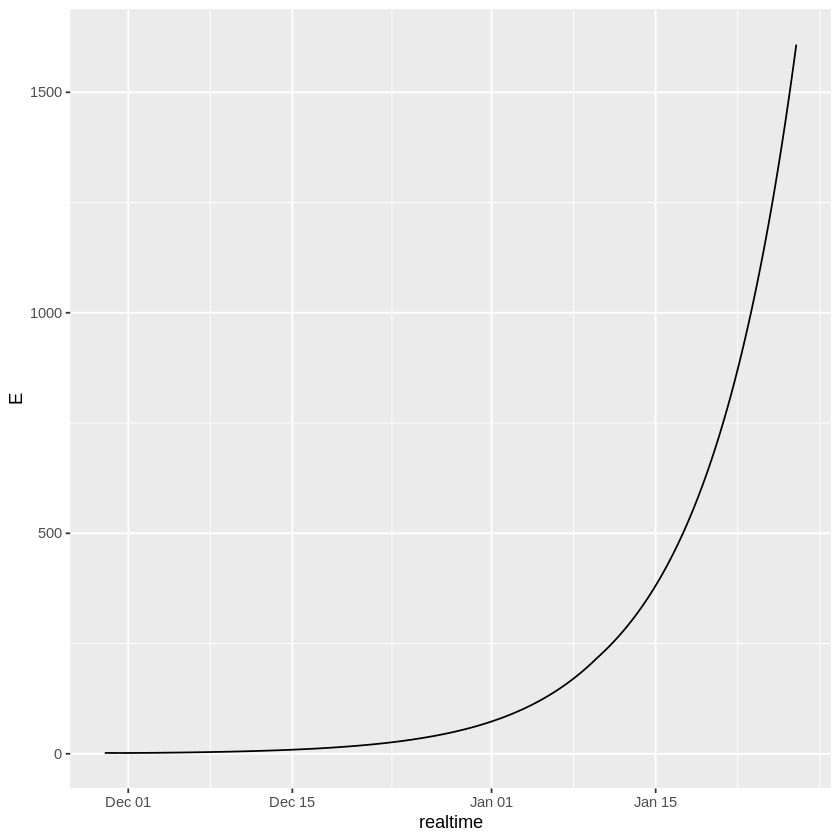

In [20]:
out = as.data.frame(ode(y= state, times=times,  func=ccwumodel, parms=cpars,
                       chuinput=mychuinput))
out$realtime=out$time+cpars$startTime
ggplot(data=out, aes(x=realtime,y=E))+geom_line() 

For both models it would be nice to see how they visually compare to the international case count data (at the time of Wu et al).   We also wish to set up the necessary functions for a likelihood model, and define the (negative log) likelihood. These are related because both involve comparing the model predictions to the data. Some functions: 


In [21]:
wuloglike = function( out,pars,wufinal) {
  # get lambda_d from 'out' which is the model output 
  ld=vapply(wufinal$day, function(x) getlambd(out,pars,x), FUN.VALUE = 1)
  return( sum((-ld) + wufinal$xd*(log(ld)) - log( factorial(wufinal$xd))))
  } 
# this function computes lambda_d in Wu et al, for the days specified in our wufinal (or ccwufinal - offset for our alternative starting time)
modelpreds = function(out, pars, wufinal) {
 ld= vapply(wufinal$day, function(x) getlambd(out,pars,x), FUN.VALUE = 1)
 return(data.frame(day=wufinal$day, prediction=ld,data=wufinal$xd))
}
getlambd = function(out,pars,day) {
  try(if(var(diff(out$time)) >0.005) {  stop("approx integral assumes equal time steps")} )
 try(if( max(out$time) < day) {stop("model simulation is not long enough for the data") })
   if (day==min(out$time)) {ii =  which(out$time >= day & out$time < day+1)
   } else {   ii = which(out$time > day-1 & out$time <= day) }
  dx=out$time[ii[2]]-out$time[ii[1]]
ft=with(pars , {(Lwi/N)*(out$E[ii] + out$I[ii])})
return( 0.5*(dx)*(ft[1]+2*sum(ft[2:(length(ft)-1)])+ft[length(ft)]))
}
# returns NEG of log likelihood
negloglike = function(R0, pars, wufinal, state,times) {
  pars$R0 = R0
  out = as.data.frame(ode(y= state, times=times,  func=wumodel, parms=pars,
                          zinput=myzinput, chuinput=mychuinput))
  return(-wuloglike(out,pars,wufinal)) 
  # NOTE optim will minimize by default, min ( -loglike) = max (log like)
}
ccnegloglike = function(R0, cpars, ccwufinal, state,times) {
  cpars$R0 = R0
  out = as.data.frame(ode(y= state, times=times,  func=ccwumodel, parms=cpars,
                        chuinput=mychuinput))
  return(-wuloglike(out,pars =cpars,ccwufinal)) 
  # NOTE optim will minimize by default, min ( -loglike) = max (log like)
}

Make a plot showing the data and the model predictions. By eye, a high $R_0$ of 3.5 looks quite good - perhaps a bit too high. We can maximize the likelihood to estimate the $R_0$ value.


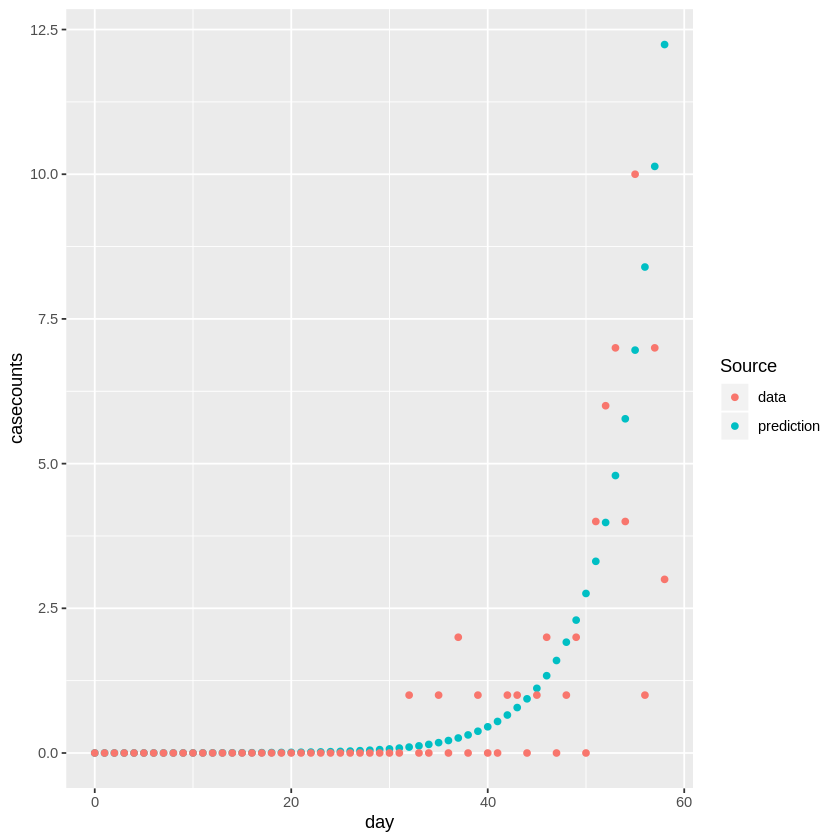

In [22]:
cpars=list(N=19000000, DL = 6,R0=3.5, DI = 8.4 - 6, Lwi=3633, Liw=3546,
       Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,startTime=as.Date("2019-11-29"),
       endTime=as.Date("2020-01-27"))
out = as.data.frame(ode(y= state, times=times,  func=ccwumodel, parms=cpars,
                       chuinput=mychuinput))
mp = modelpreds(out,cpars,ccwufinal) %>% gather(Source, casecounts, prediction:data)
ggplot(data=mp, aes(x=day,y=casecounts,color=Source))+geom_point()

We can use optim to estimate $R_0$ here. Wu et al used a Bayesian approach. We will get errors because optim expects more than one parameter to optimize over -- try it! Set up the function as a function of two parameters rather than one, and optimize them simultaneously. 


In [23]:
optim(2.5, function(R0) ccnegloglike(R0, cpars, ccwufinal,state,times))


Warning message in optim(2.5, function(R0) ccnegloglike(R0, cpars, ccwufinal, state, :
“one-dimensional optimization by Nelder-Mead is unreliable:
use "Brent" or optimize() directly”

$par
[1] 3.4151

$value
[1] 47.49085

$counts
function gradient 
      30       NA 

$convergence
[1] 0

$message
NULL

Plot the result - ie what does the simulation look like with R0=3.14151? 


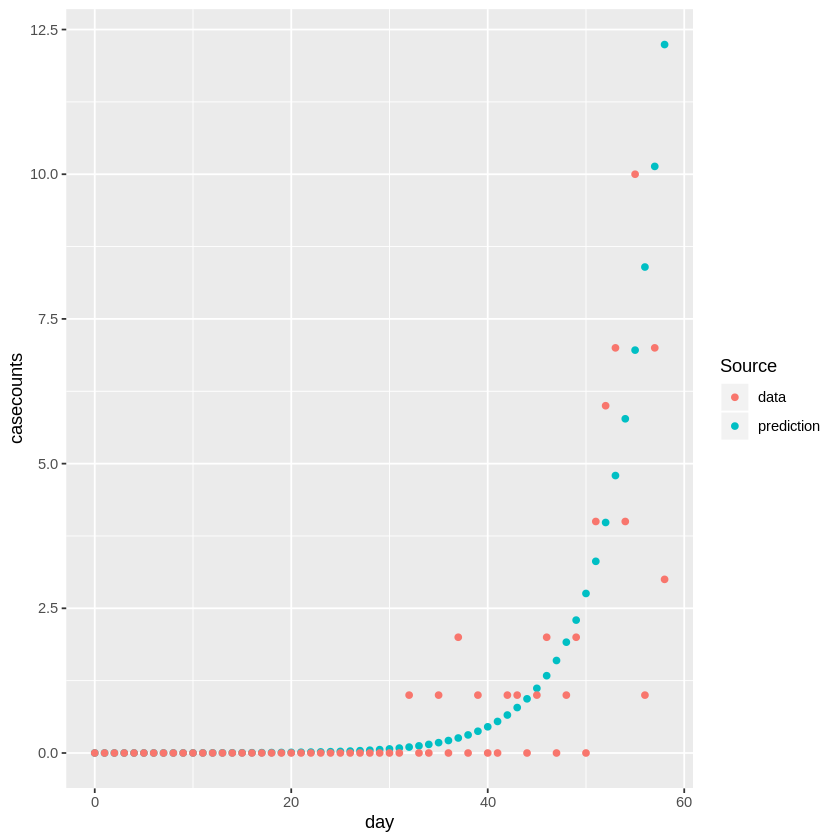

In [24]:
cpars=list(N=19000000, DL = 6,R0=3.5, DI = 8.4 - 6, Lwi=3633, Liw=3546,
       Lwc=502013, Lcw=487310, LwcCH=717226, LcwCH=810500,startTime=as.Date("2019-11-29"),
       endTime=as.Date("2020-01-27"))
out = as.data.frame(ode(y= state, times=times,  func=ccwumodel, parms=cpars,
                       chuinput=mychuinput))
mp = modelpreds(out,cpars,ccwufinal) %>% gather(Source, casecounts, prediction:data)
ggplot(data=mp, aes(x=day,y=casecounts,color=Source))+geom_point() #

This model requires either a very high initial force of introduction or quite a high value of the basic reproduction number, if the other parameters are correct, in order to match the international case count data. 

## Questions and suggestions 

In the above, we have compared the international case counts to the model predictions for the number of cases that flew on that day. This does not give individuals any delay time between flying and symptom onset. If there were such a delay (ie the individual flew out of Wuhan some days before symptom onset), then the model would have to be generating more cases earlier, and the estimate of R0 should rise. 

We also did not do any imputation where cases were missing a time of symptom onset, so we have not used some of the data. Impute the missing times using the mean time between onset and confirmation, and re-do the analysis. 

The serial interval and incubation periods were fixed. How does the estimate of R0 change if these are changed? If they are simultaneously estimated, what are some of the tradeoffs?

The Poisson assumption in the likelihood does not account for possible over-dispersion; what if a negative binomial distribution is used instead - does that change the estimated value? 
